In [9]:
from astroquery.gaia import Gaia
import numpy as np
Gaia.login()

INFO: Login to gaia TAP server [astroquery.gaia.core]


User:  lpalaver
Password:  ········


INFO: OK [astroquery.utils.tap.core]
INFO: Login to gaia data server [astroquery.gaia.core]
INFO: OK [astroquery.utils.tap.core]


In [12]:
cd "/mnt/beegfs/scratch/data/Gaia-SDSS/fits/all_in_one/"

/mnt/beegfs/scratch/data/Gaia-SDSS/fits/all_in_one


/nvme/lovro/miniconda3/envs/photod-testing/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [13]:
pwd

'/mnt/beegfs/scratch/data/Gaia-SDSS/fits/all_in_one'

Crossmatch Gaia stars with "good" parallaxes to SDSS photometry.

N.B. Parallaxes may be simply inverted to distances if parallax_over_error > 10 (this is a rough approximation!).

In [ ]:
for i,j in zip(np.arange(0, 2000000000, 100000000)[:-1], np.arange(0, 2000000000, 100000000)[1:]):
    query = f"SELECT G.random_index, G.ra, G.dec, G.phot_g_mean_mag, G.parallax, G.parallax_error, D.*,\
	S.objid, S.type, S.psfmag_u, S.psfmag_g, S.psfmag_r, S.psfmag_i, S.psfmag_z, S.psfmagerr_u, S.psfmagerr_g, S.psfmagerr_r, S.psfmagerr_i, S.psfmagerr_z, \
    S.extinction_u, S.extinction_g, S.extinction_r, S.extinction_i, S.extinction_z \
FROM gaiadr3.gaia_source AS G \
JOIN external.gaiaedr3_distance AS D ON G.source_id = D.source_id \
JOIN gaiadr3.sdssdr13_best_neighbour AS BN ON G.source_id = BN.source_id \
JOIN external.sdssdr13_photoprimary AS S ON BN.original_ext_source_id = S.objid \
WHERE G.parallax_over_error > 5 \
	AND G.visibility_periods_used > 10 \
	AND G.ruwe < 1.4 \
	AND G.in_qso_candidates = 'f' \
	AND G.in_galaxy_candidates = 'f' \
	AND G.random_index >= {i} \
	AND G.random_index <  {j}".format(i, j)
    print(i, j, "\n", query, "\n")
    job = Gaia.launch_job_async(query, dump_to_file=True, output_format='fits')

0 100000000 
 SELECT G.random_index, G.ra, G.dec, G.phot_g_mean_mag, G.parallax, G.parallax_error, D.*,	S.objid, S.type, S.psfmag_u, S.psfmag_g, S.psfmag_r, S.psfmag_i, S.psfmag_z, S.psfmagerr_u, S.psfmagerr_g, S.psfmagerr_r, S.psfmagerr_i, S.psfmagerr_z,     S.extinction_u, S.extinction_g, S.extinction_r, S.extinction_i, S.extinction_z FROM gaiadr3.gaia_source AS G JOIN external.gaiaedr3_distance AS D ON G.source_id = D.source_id JOIN gaiadr3.sdssdr13_best_neighbour AS BN ON G.source_id = BN.source_id JOIN external.sdssdr13_photoprimary AS S ON BN.original_ext_source_id = S.objid WHERE G.parallax_over_error > 5 	AND G.visibility_periods_used > 10 	AND G.ruwe < 1.4 	AND G.in_qso_candidates = 'f' 	AND G.in_galaxy_candidates = 'f' 	AND G.random_index >= 0 	AND G.random_index <  100000000 

100000000 200000000 
 SELECT G.random_index, G.ra, G.dec, G.phot_g_mean_mag, G.parallax, G.parallax_error, D.*,	S.objid, S.type, S.psfmag_u, S.psfmag_g, S.psfmag_r, S.psfmag_i, S.psfmag_z, S.psfmagerr_

In [16]:
from dask.distributed import Client
from hats_import.pipeline import pipeline_with_client
from hats_import.catalog.arguments import ImportArguments

In [17]:
client = Client(n_workers=96, threads_per_worker=1, memory_limit="15GiB")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 96
Total threads: 96,Total memory: 1.41 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45077,Workers: 96
Dashboard: http://127.0.0.1:8787/status,Total threads: 96
Started: Just now,Total memory: 1.41 TiB
Comm: tcp://127.0.0.1:41645,Total threads: 1
Dashboard: http://127.0.0.1:46531/status,Memory: 15.00 GiB
Nanny: tcp://127.0.0.1:33067,


2024-12-14 20:59:58,194 - distributed.nanny - WARNING - Restarting worker


In [26]:
pwd

'/mnt/beegfs/scratch/data/Gaia-SDSS'

In [27]:
args = ImportArguments(
    sort_columns="source_id",
    ra_column="ra",
    dec_column="dec",
    input_path="/mnt/beegfs/scratch/data/Gaia-SDSS/fits/",
    file_reader="fits",
    output_artifact_name="Gaia-SDSS_w_extinctions",
    output_path="/mnt/beegfs/scratch/data/Gaia-SDSS/hats/",
    resume=False
)

In [28]:
pipeline_with_client(args, client)

Planning  :   0%|          | 0/4 [00:00<?, ?it/s]

Mapping   :   0%|          | 0/19 [00:00<?, ?it/s]

Binning   :   0%|          | 0/2 [00:00<?, ?it/s]

Splitting :   0%|          | 0/19 [00:00<?, ?it/s]

Reducing  :   0%|          | 0/63 [00:00<?, ?it/s]

Finishing :   0%|          | 0/4 [00:00<?, ?it/s]

### Merge the table with SDSS extinctions. First import it into HATS.

In [2]:
import lsdb

df = lsdb.read_hats("/mnt/beegfs/scratch/data/Gaia-SDSS/hats/Gaia-SDSS_w_extinctions/")
df

,random_index,ra,dec,phot_g_mean_mag,parallax,parallax_error,source_id,r_med_geo,r_lo_geo,r_hi_geo,r_med_photogeo,r_lo_photogeo,r_hi_photogeo,flag,objid,type,psfmag_u,psfmag_g,psfmag_r,psfmag_i,psfmag_z,psfmagerr_u,psfmagerr_g,psfmagerr_r,psfmagerr_i,psfmagerr_z,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z,Norder,Dir,Npix
npartitions=63,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Order: 1, Pixel: 0",int64[pyarrow],double[pyarrow],double[pyarrow],float[pyarrow],double[pyarrow],float[pyarrow],int64[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],string[pyarrow],int64[pyarrow],int16[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow]
"Order: 1, Pixel: 1",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 0, Pixel: 10",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 0, Pixel: 11",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Catalog pixel density map - Gaia-SDSS_w_extinctions'}>)

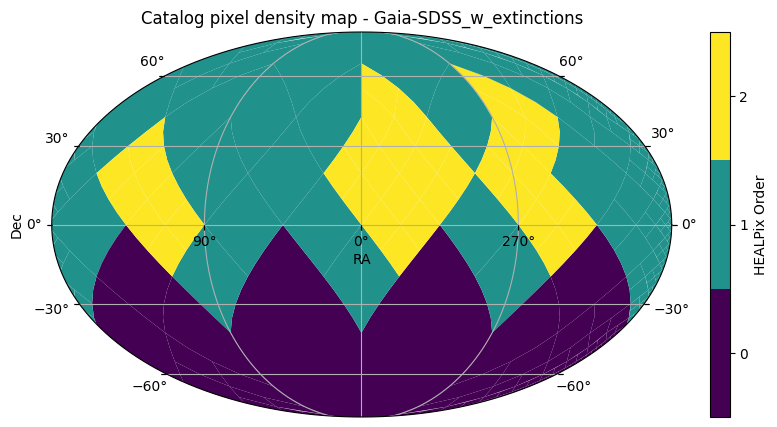

In [33]:
df.plot_pixels()

/nvme/lovro/miniconda3/envs/photod-testing/lib/python3.12/site-packages/hats/inspection/visualize_catalog.py:309: UserWarning: This plot contains HEALPix pixels smaller than a pixel of the plot. Some values may be lost
  warnings.warn(


(<Figure size 1000x500 with 2 Axes>, <WCSAxes: >)

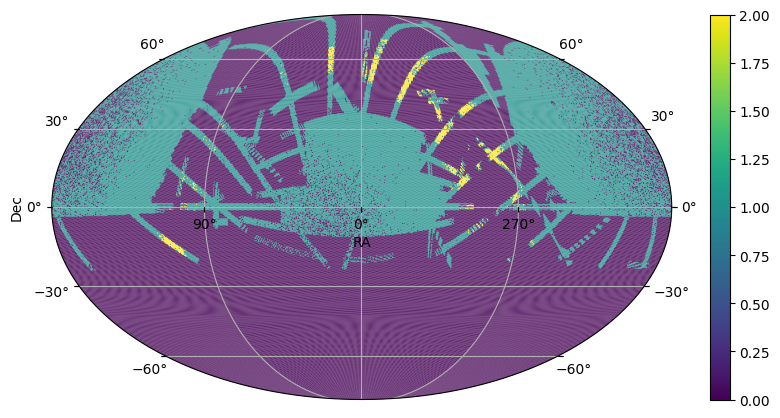

In [36]:
# df.skymap_histogram(lambda df, a: np.log10(len(df)+1), order=9)
df.skymap(lambda df, a: np.log10(len(df)+1), order=9)